# User clustering model for mobile apps

Clustering users based on spending behavior, using the RFM features

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report # used for text report showing the main classification metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### Importing dataset

In [11]:
df = pd.read_csv('C:/Users/Hashem Ashour/Desktop/Model analysis/User Clustering/datasets/rfm_ios.csv')
df

USERID  RECENCY  FREQUENCY  MONETARY
0      5c66256e-ba14-4183-a388-7000afb385f2       31          6     18.94
1          797f8e06cfee5c81915774e9034b309b      713          5     34.94
2          efa21e602b31588072cd825b708b6aec      491         13    102.87
3          4d98c3a0ac5894936d2f91403bdfc4f3     1014          1      0.99
4      2d8e19e1-f32c-4937-9d0c-5a222debbfdf      142          1      2.99
...                                     ...      ...        ...       ...
65620  21da8b44-da4a-45bd-83bc-b7c54e5c00f8      225          1      5.99
65621  844c548c-955e-4660-9dd4-3809162c9f25       32         11      2.99
65622      8a9a22810cdd2b93e66dc79e50025d69      485          1      0.99
65623      8576497457f4565ab87a888abd0852d2      726          1      6.99
65624  da472dd8-3728-45f8-8fa2-c80c3c53bf87      904          1      2.99

[65625 rows x 4 columns]

In [12]:
rfm = df.copy()
rfm

USERID  RECENCY  FREQUENCY  MONETARY
0      5c66256e-ba14-4183-a388-7000afb385f2       31          6     18.94
1          797f8e06cfee5c81915774e9034b309b      713          5     34.94
2          efa21e602b31588072cd825b708b6aec      491         13    102.87
3          4d98c3a0ac5894936d2f91403bdfc4f3     1014          1      0.99
4      2d8e19e1-f32c-4937-9d0c-5a222debbfdf      142          1      2.99
...                                     ...      ...        ...       ...
65620  21da8b44-da4a-45bd-83bc-b7c54e5c00f8      225          1      5.99
65621  844c548c-955e-4660-9dd4-3809162c9f25       32         11      2.99
65622      8a9a22810cdd2b93e66dc79e50025d69      485          1      0.99
65623      8576497457f4565ab87a888abd0852d2      726          1      6.99
65624  da472dd8-3728-45f8-8fa2-c80c3c53bf87      904          1      2.99

[65625 rows x 4 columns]

### Visualising data distribution for outlier detection

Text(0.5, 0, 'Attributes')

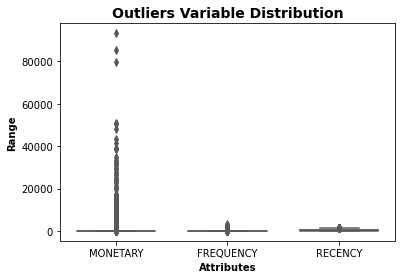

In [13]:
attributes = ['MONETARY','FREQUENCY','RECENCY']
#plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

### Outlier detection: interquartile range

In [14]:
q3 = rfm.MONETARY.quantile(0.75)
q1 = rfm.MONETARY.quantile(0.25)
iqr = q3 - q1
print(max(rfm.MONETARY))
print(iqr)
print(q3 + 1.5*iqr)
print(rfm[rfm.MONETARY > q3 + 1.5*iqr])
q3

93332.31
62.809999999999995
160.015
                                     USERID  RECENCY  FREQUENCY  MONETARY
7          47ba3ff91b3dfecd0c1ce47771fc71b4       78         65    727.27
13         37a20dacb07455b7d4dc9125526eb57a       49         31    230.69
21         20978e89e918ab0e903e7d937ebd9511      175         43    645.48
34     63d26df6-8fd5-42a0-a763-830bbe013aa7       89         24    274.73
35         e2c5811bc04a0a60f22011fb2edf1a4e      116        150   2215.73
...                                     ...      ...        ...       ...
65605  810ca670-4df4-47ad-a8c2-140a0e12633b       10        223   3238.02
65608      054fc6578e11d98a5d8dd5cfdd2980fc      345          6    227.93
65611      236e9f8db4e539c158a5ceb5302cb0c7      393         53    777.39
65616      17130b32d1b37828d6347a3824dcb5ca       55         75    470.24
65619  e2901723-2387-4300-8271-463e2823aded      204          4    210.95

[8877 rows x 4 columns]


65.8

In [15]:
# Removing (statistical) outliers for MONETARY
Q1 = rfm.MONETARY.quantile(0.25)
Q3 = rfm.MONETARY.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.MONETARY >= Q1 - 1.5*IQR) & (rfm.MONETARY <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for RECENCY
Q1 = rfm.RECENCY.quantile(0.35)
Q3 = rfm.RECENCY.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.RECENCY >= Q1 - 1.5*IQR) & (rfm.RECENCY <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for FREQUENCY
Q1 = rfm.FREQUENCY.quantile(0.25)
Q3 = rfm.FREQUENCY.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.FREQUENCY >= Q1 - 1.5*IQR) & (rfm.FREQUENCY <= Q3 + 1.5*IQR)]

rfm

USERID  RECENCY  FREQUENCY  MONETARY
0      5c66256e-ba14-4183-a388-7000afb385f2       31          6     18.94
1          797f8e06cfee5c81915774e9034b309b      713          5     34.94
2          efa21e602b31588072cd825b708b6aec      491         13    102.87
3          4d98c3a0ac5894936d2f91403bdfc4f3     1014          1      0.99
4      2d8e19e1-f32c-4937-9d0c-5a222debbfdf      142          1      2.99
...                                     ...      ...        ...       ...
65620  21da8b44-da4a-45bd-83bc-b7c54e5c00f8      225          1      5.99
65621  844c548c-955e-4660-9dd4-3809162c9f25       32         11      2.99
65622      8a9a22810cdd2b93e66dc79e50025d69      485          1      0.99
65623      8576497457f4565ab87a888abd0852d2      726          1      6.99
65624  da472dd8-3728-45f8-8fa2-c80c3c53bf87      904          1      2.99

[49283 rows x 4 columns]

Text(0.5, 0, 'Attributes')

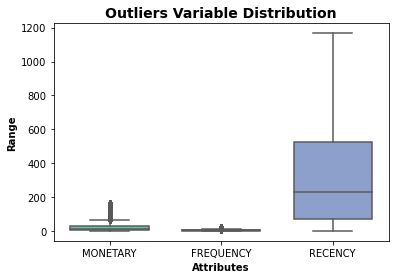

In [16]:
attributes = ['MONETARY','FREQUENCY','RECENCY']
#plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

### Rescaling our data: using standardization

In [17]:
# instantiate the scaler
scaler = StandardScaler()

# fit_transform
to_scale = rfm[['RECENCY', 'FREQUENCY', 'MONETARY']]
rfm_scaled = scaler.fit_transform(to_scale)
rfm_scaled = pd.DataFrame(rfm_scaled)
rfm_scaled.columns = ['Recency', 'Frequency', 'Monetary']
print(rfm_scaled.shape)
rfm_scaled

(49283, 3)


Recency  Frequency  Monetary
0     -0.991713   0.393786 -0.109976
1      1.288932   0.153381  0.418458
2      0.546552   2.076624  2.661993
3      2.295492  -0.808241 -0.702814
4     -0.620523  -0.808241 -0.636759
...         ...        ...       ...
49278 -0.342967  -0.808241 -0.537678
49279 -0.988369   1.595814 -0.636759
49280  0.526487  -0.808241 -0.702814
49281  1.332405  -0.808241 -0.504651
49282  1.927646  -0.808241 -0.636759

[49283 rows x 3 columns]

Text(0.5, 0, 'Attributes')

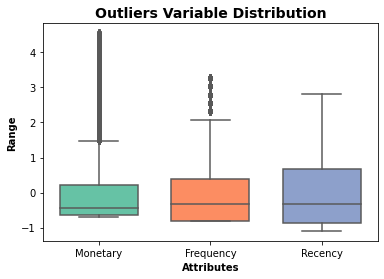

In [18]:
attributes = ['Monetary','Frequency','Recency']
#plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm_scaled[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

# Building the model

### Elbow method for finding ideal number of clusters

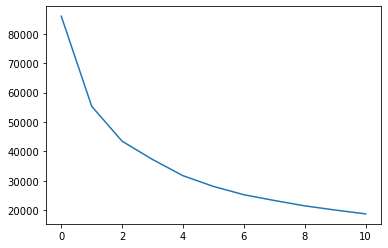

In [19]:
inertia = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, n_init = 100, max_iter= 300)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(inertia)

### Sillhoute method for finding ideal number of clusters

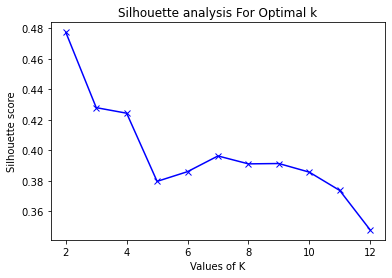

In [20]:
import matplotlib.pyplot as plt

silhouette_avg= []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for num_clusters in range_n_clusters:
    
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, n_init = 50, max_iter = 200)
    kmeans.fit(rfm_scaled)
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg.append(silhouette_score(rfm_scaled, cluster_labels)) 
    
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

<IPython.core.display.Javascript object>


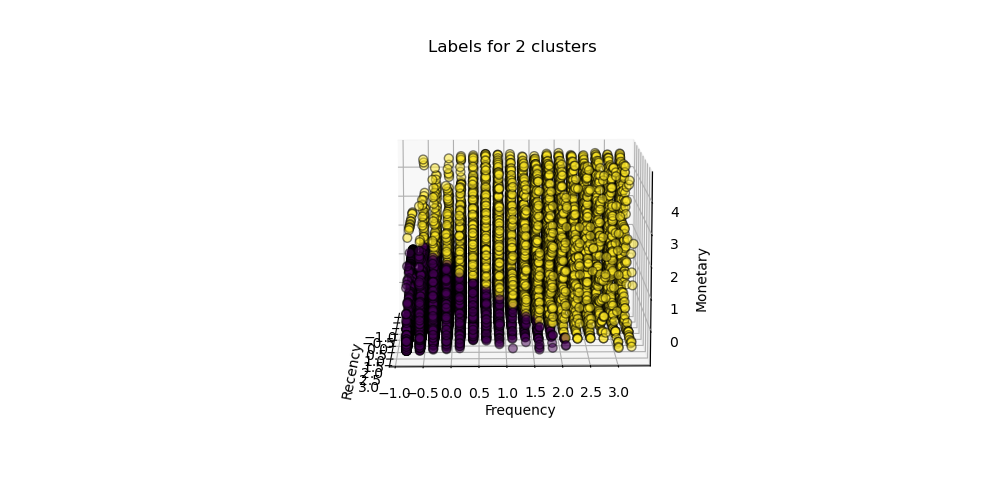

<IPython.core.display.Javascript object>


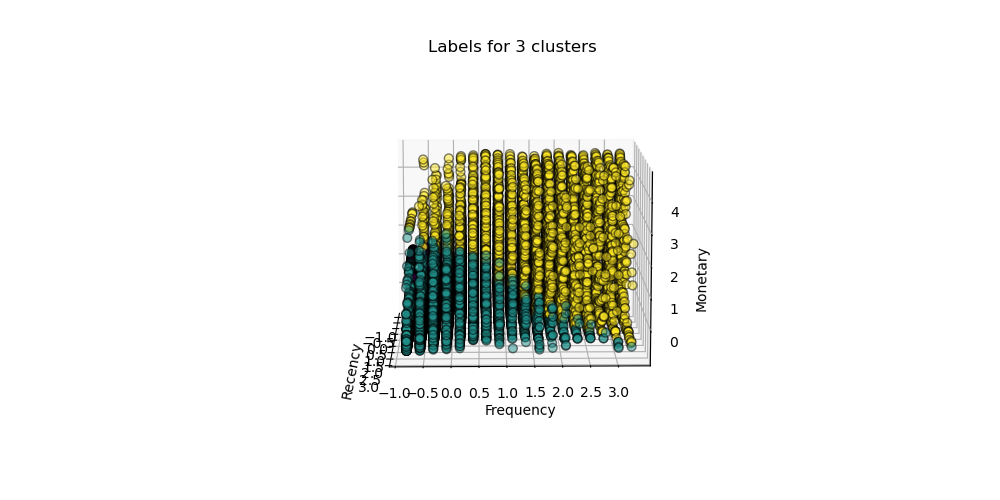

<IPython.core.display.Javascript object>


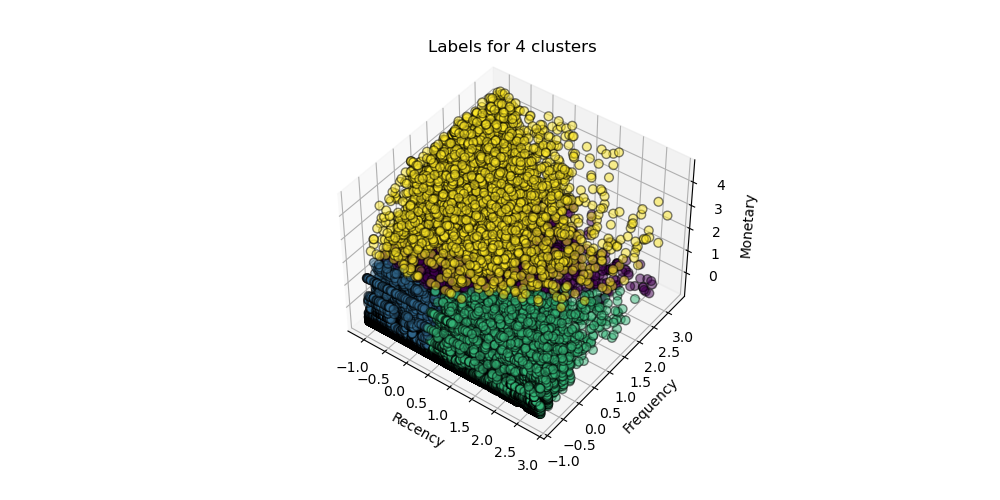

<IPython.core.display.Javascript object>


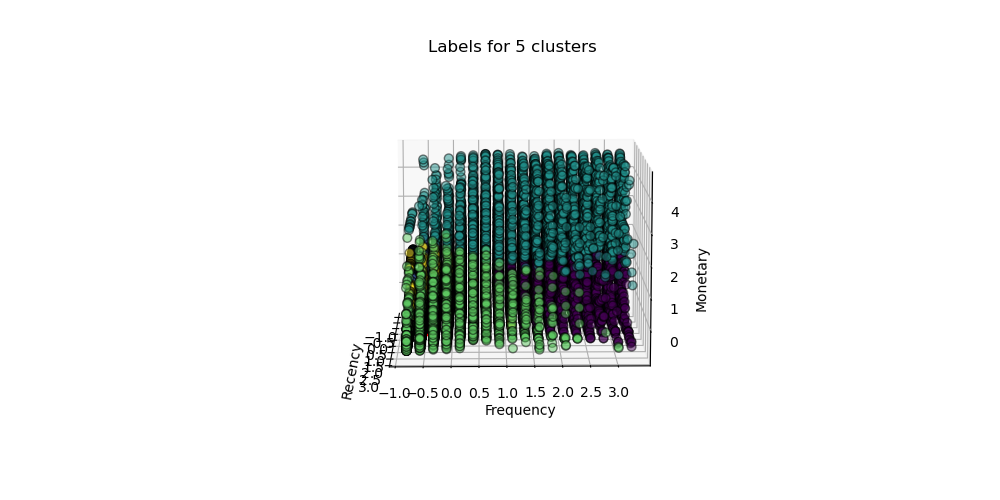

<IPython.core.display.Javascript object>


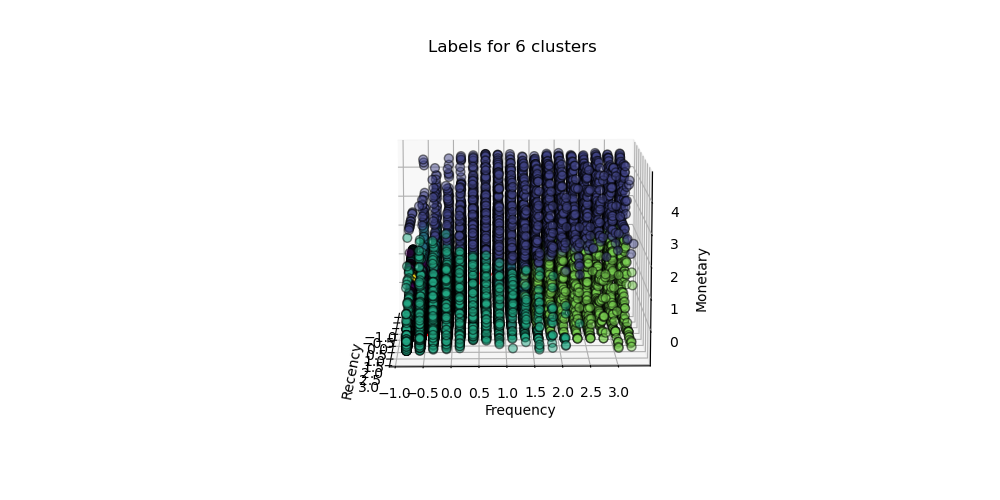

<IPython.core.display.Javascript object>


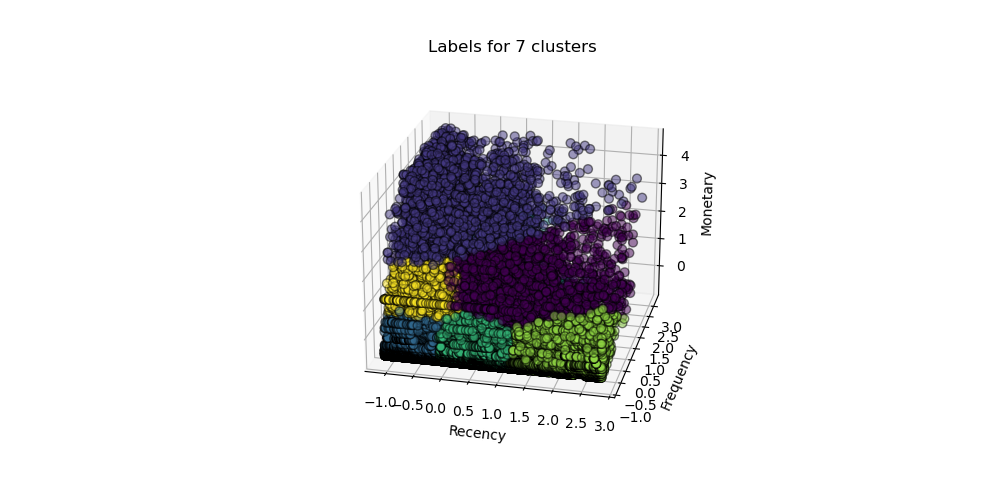

<IPython.core.display.Javascript object>


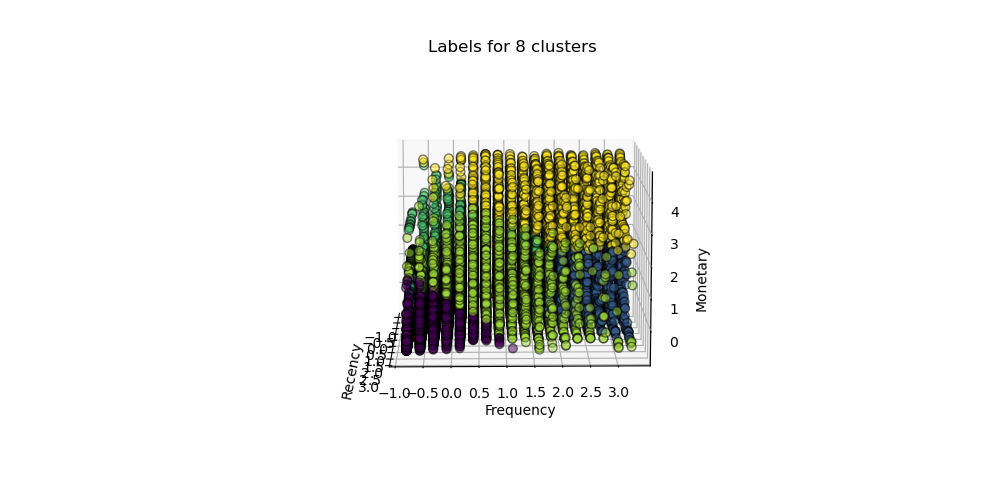

<IPython.core.display.Javascript object>


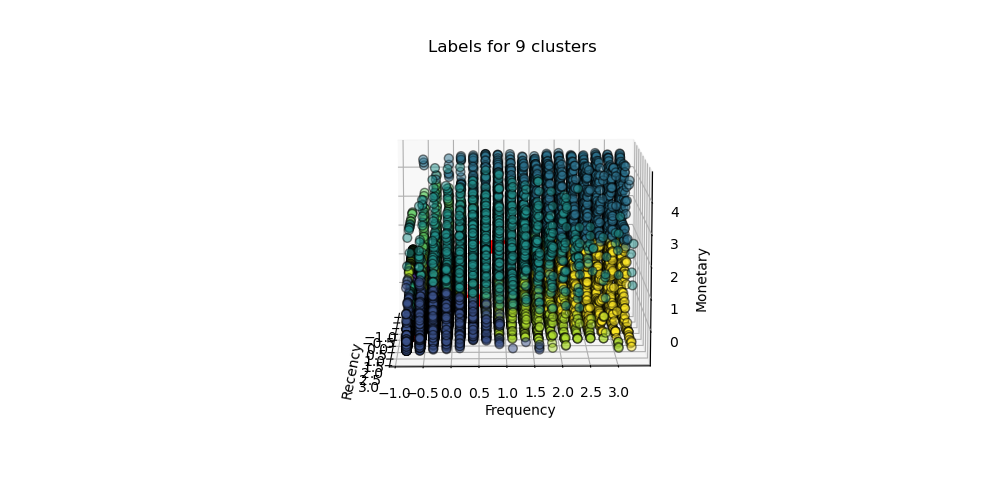

<IPython.core.display.Javascript object>


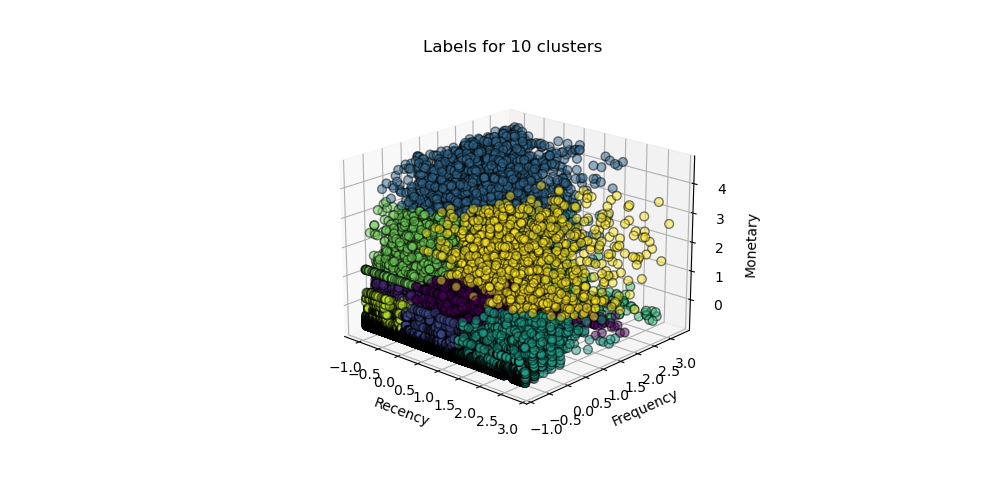

<IPython.core.display.Javascript object>


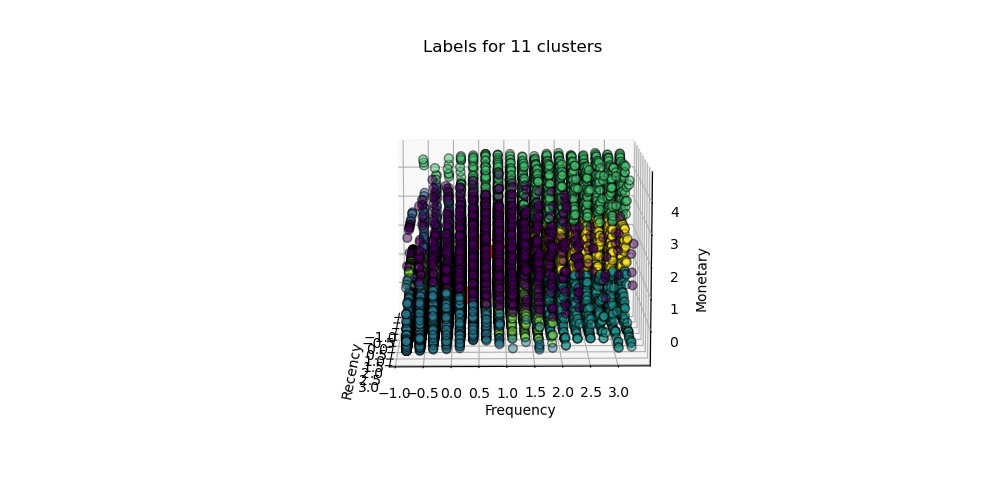

<IPython.core.display.Javascript object>


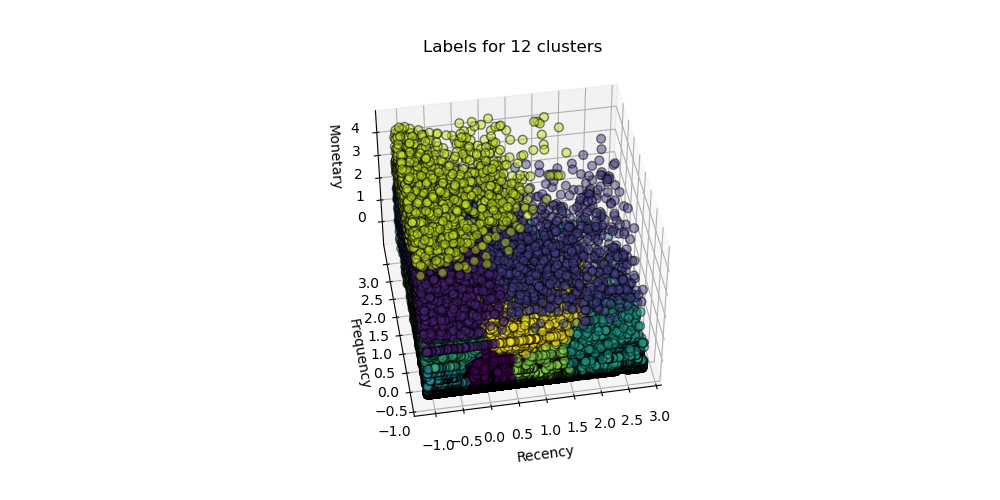

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt

silhouette_avg = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


for num_clusters in range_n_clusters:
    
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, n_init = 50, max_iter = 200)
    kmeans.fit(rfm_scaled)
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg.append(silhouette_score(rfm_scaled, cluster_labels)) 
    
    
    ### plotting the data distribution for each set of clusters
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(rfm_scaled.Recency,rfm_scaled.Frequency,rfm_scaled.Monetary, 
                c=cluster_labels, cmap='viridis',
                edgecolor='k', s=40, alpha = 0.5)
    
    

    #print("number of clusters: %s")
    ax.set_title("Labels for %s clusters" % num_clusters)
    ax.set_xlabel("Recency")
    ax.set_ylabel("Frequency")
    ax.set_zlabel("Monetary")
    ax.dist = 10
    
    for angle in range(0, 360):
        ax.view_init(10, angle)
        plt.draw()
        plt.pause(.001)

    ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
               kmeans.cluster_centers_[:,2], 
               s = 300, c = 'r', marker='*', label = 'Centroid')

    plt.autoscale(enable=True, axis='x', tight=True)    

    plt.show()



## Choosing 4 clusters for our analysis based on the 'elbow method' and 'sillhoute score'

### Fitting the best model for our 4 clusters

In [14]:
kmeans = KMeans(n_clusters= 4, n_init = 50, max_iter = 200)
kmeans.fit(rfm_scaled)
cluster_labels = kmeans.labels_
rfm['Cluster_Id'] = kmeans.labels_
final = rfm.copy()
final

USERID  RECENCY  FREQUENCY  MONETARY  \
0      5c66256e-ba14-4183-a388-7000afb385f2       31          6     18.94   
1          797f8e06cfee5c81915774e9034b309b      713          5     34.94   
2          efa21e602b31588072cd825b708b6aec      491         13    102.87   
3          4d98c3a0ac5894936d2f91403bdfc4f3     1014          1      0.99   
4      2d8e19e1-f32c-4937-9d0c-5a222debbfdf      142          1      2.99   
...                                     ...      ...        ...       ...   
65620  21da8b44-da4a-45bd-83bc-b7c54e5c00f8      225          1      5.99   
65621  844c548c-955e-4660-9dd4-3809162c9f25       32         11      2.99   
65622      8a9a22810cdd2b93e66dc79e50025d69      485          1      0.99   
65623      8576497457f4565ab87a888abd0852d2      726          1      6.99   
65624  da472dd8-3728-45f8-8fa2-c80c3c53bf87      904          1      2.99   

       Cluster_Id  
0               1  
1               2  
2               2  
3               2  
4               1  
...           ...  
65620           1  
65621           1  
65622           2  
65623           2  
65624           2  

[63878 rows x 5 columns]

In [15]:
final['Cluster_Id'].value_counts(normalize = True)

1    0.565672
2    0.282820
0    0.118648
3    0.032860
Name: Cluster_Id, dtype: float64

<IPython.core.display.Javascript object>


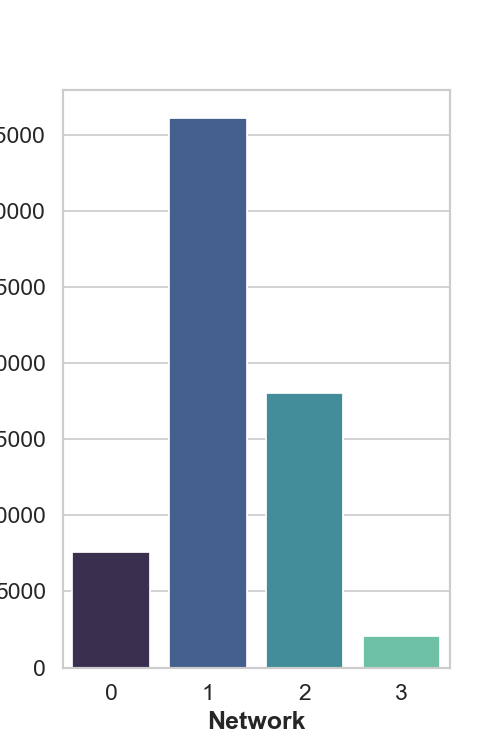

Text(0, 0.5, 'Number of users')

In [16]:
sns.set(style = 'whitegrid', font_scale = 1.2)
fig = plt.figure(figsize = [4,6])
ax = sns.countplot(data=final, x = 'Cluster_Id', palette = 'mako')
plt.xlabel('Network', weight = 'bold')
plt.ylabel('Number of users', weight = 'bold')

# Visualizing the final cluster distribution based on the given RFM parameters

### Recency Distribution

<IPython.core.display.Javascript object>


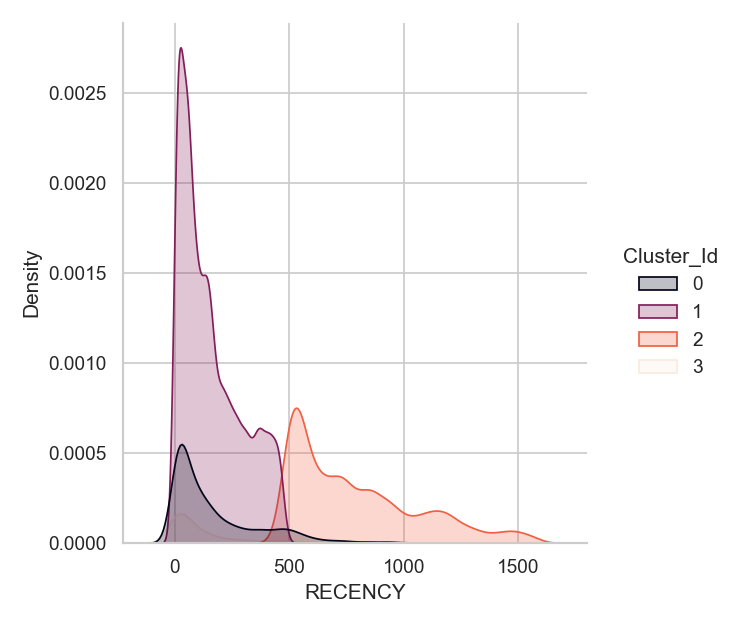

In [44]:
sns.set_theme(style="whitegrid")
sns.displot(final, x="RECENCY", hue="Cluster_Id", kind="kde", fill=True, palette= "rocket")

<IPython.core.display.Javascript object>


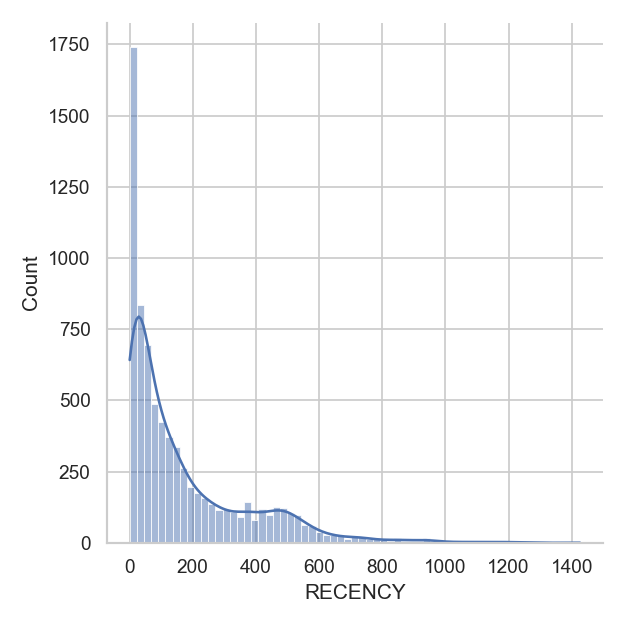

<IPython.core.display.Javascript object>


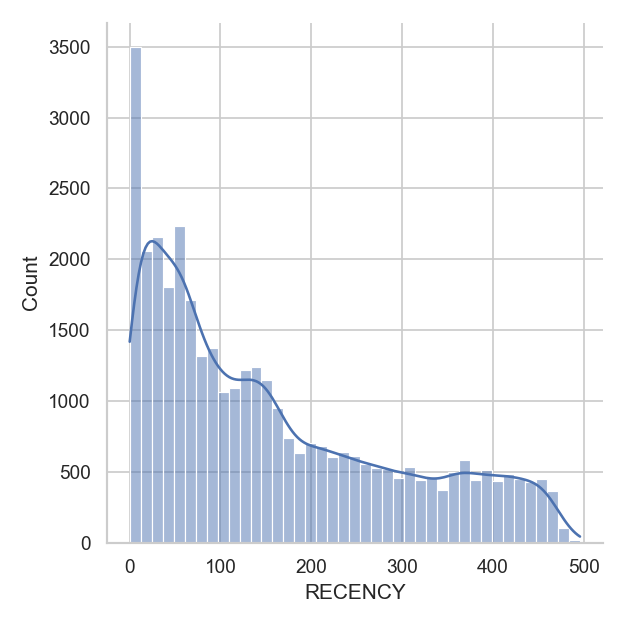

<IPython.core.display.Javascript object>


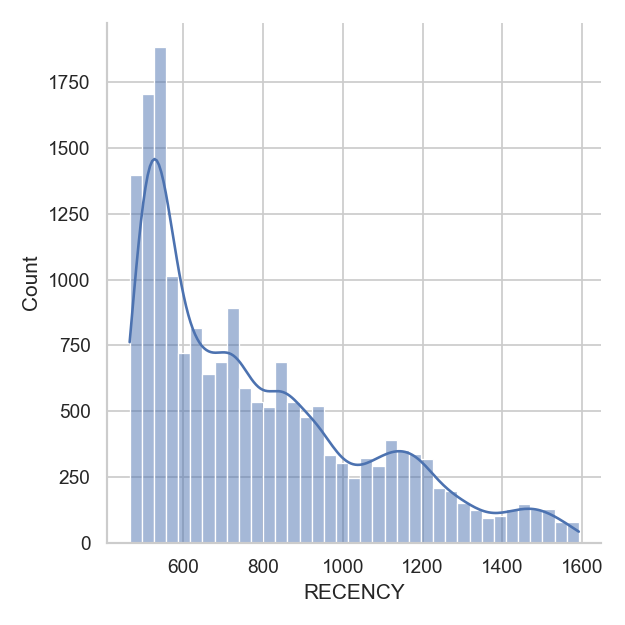

<IPython.core.display.Javascript object>


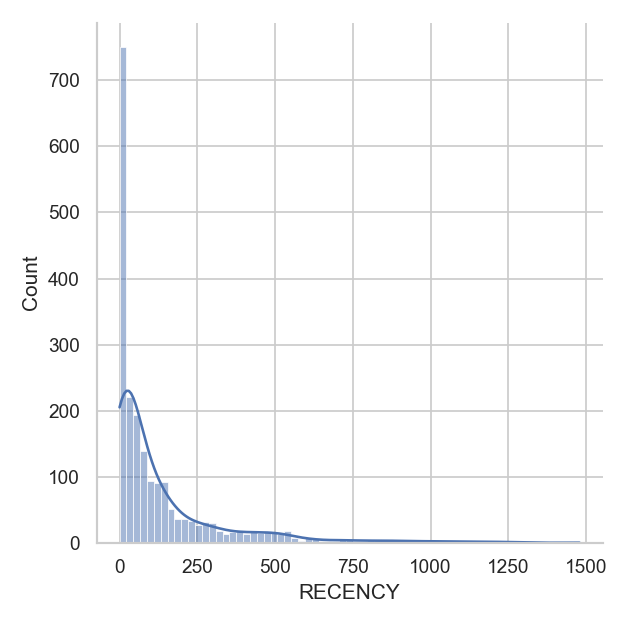

In [82]:
for i in range(4):
    sns.set_theme(style="whitegrid")
    sns.displot(data= final[final['Cluster_Id']== i], x="RECENCY", kde=True, fill=True, palette= "rocket")

#data=df_original[df_original['TypeTravel'] == 'Personal Travel']

### Frequency Distribution

<IPython.core.display.Javascript object>


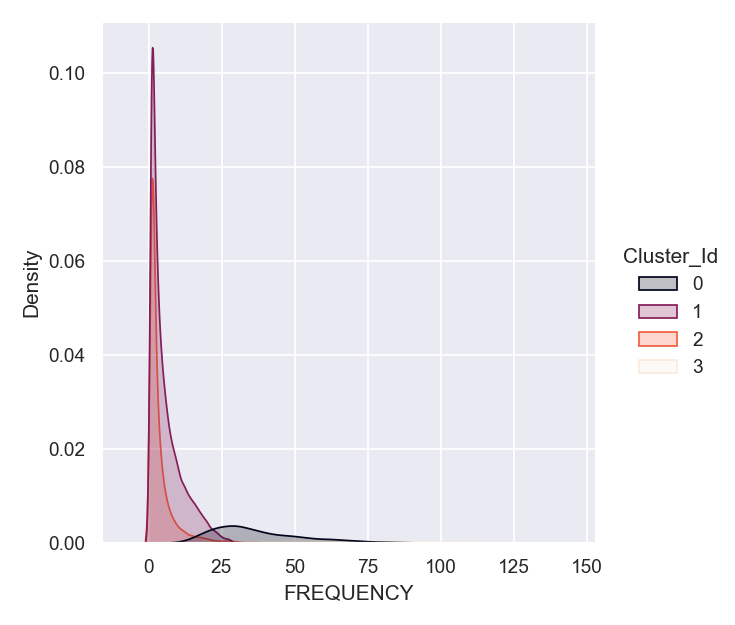

In [36]:
sns.set_theme(style="darkgrid")
sns.displot(final, x="FREQUENCY", hue="Cluster_Id", kind="kde", fill=True, palette= "rocket")

<IPython.core.display.Javascript object>


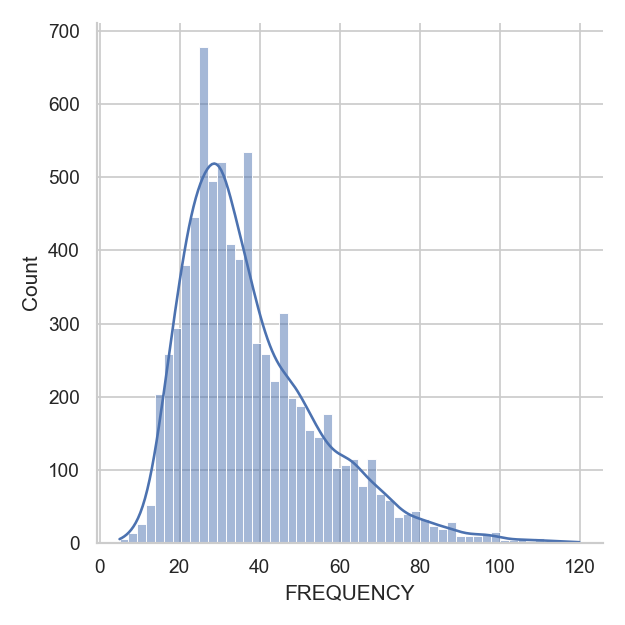

<IPython.core.display.Javascript object>


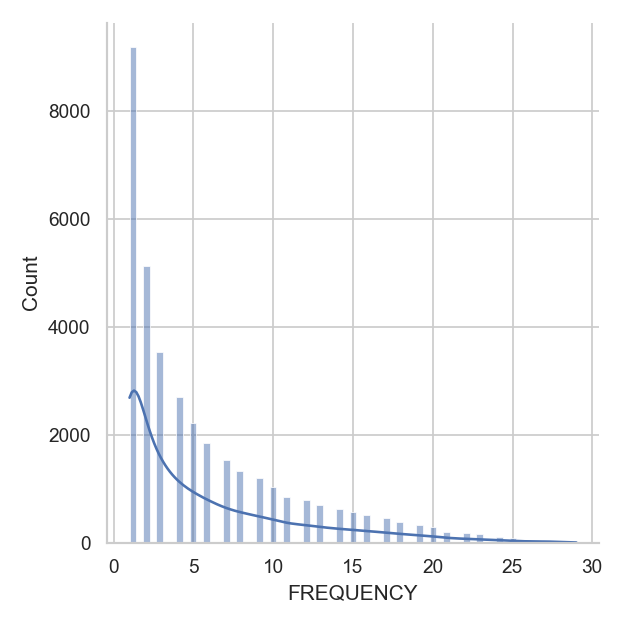

<IPython.core.display.Javascript object>


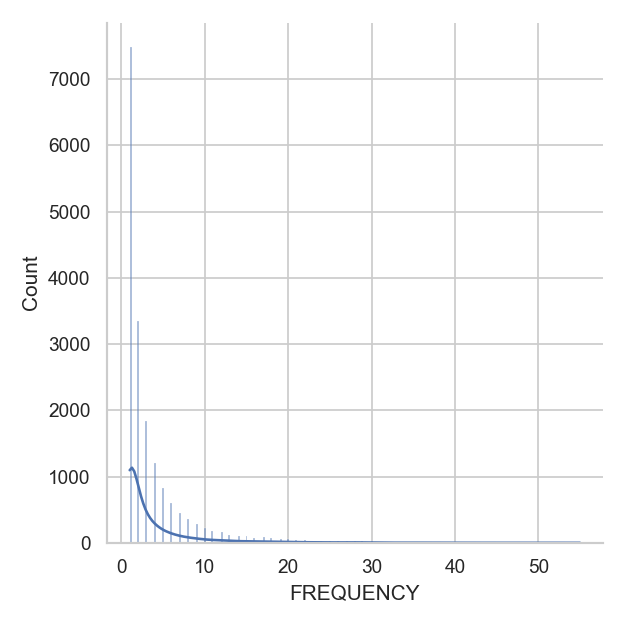

<IPython.core.display.Javascript object>


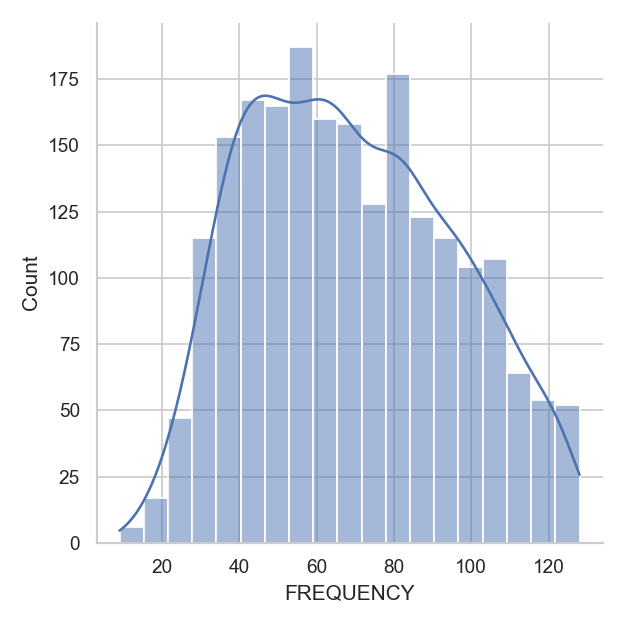

In [84]:
for i in range(4):
    sns.set_theme(style="whitegrid")
    sns.displot(data= final[final['Cluster_Id']== i], x="FREQUENCY", kde=True, fill=True, palette= "rocket")

### Monetary distribution

<IPython.core.display.Javascript object>


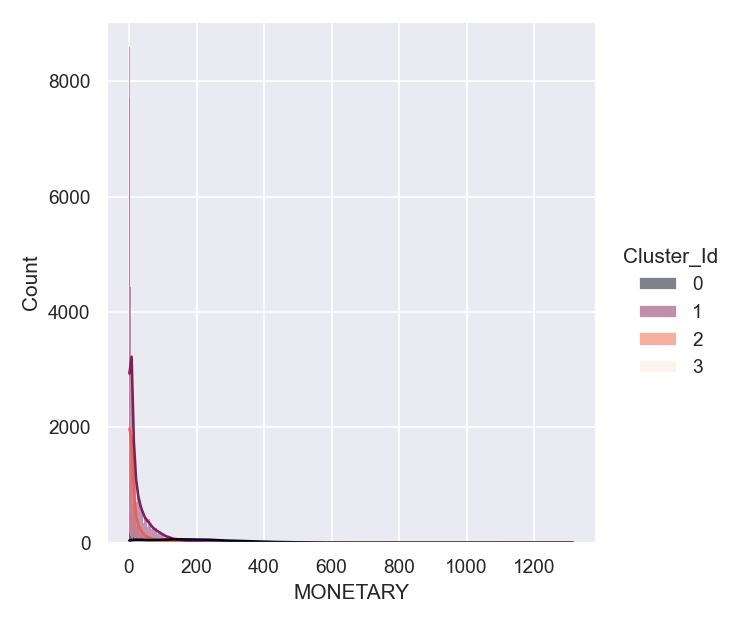

In [42]:
sns.set_theme(style="darkgrid")
sns.displot(final, x="MONETARY", hue="Cluster_Id", kde=True, fill=True, palette = 'rocket')

<IPython.core.display.Javascript object>


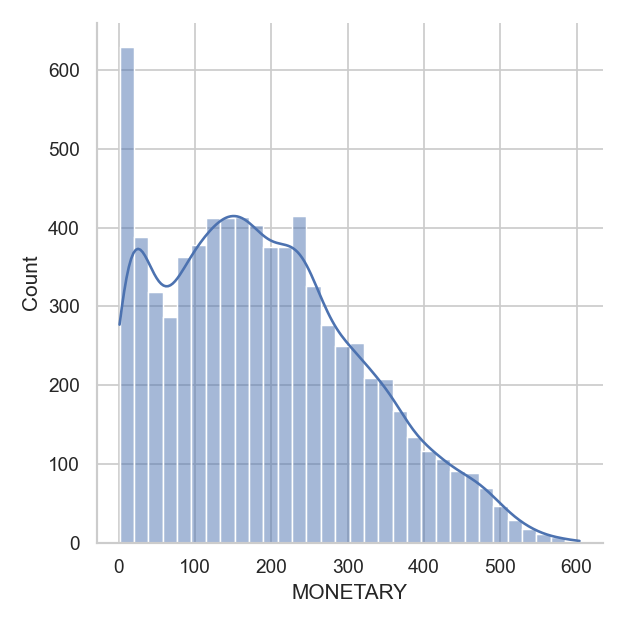

<IPython.core.display.Javascript object>


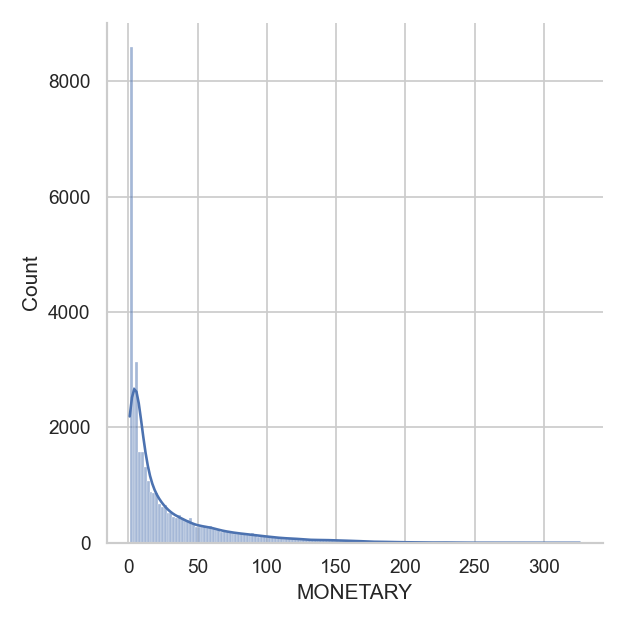

<IPython.core.display.Javascript object>


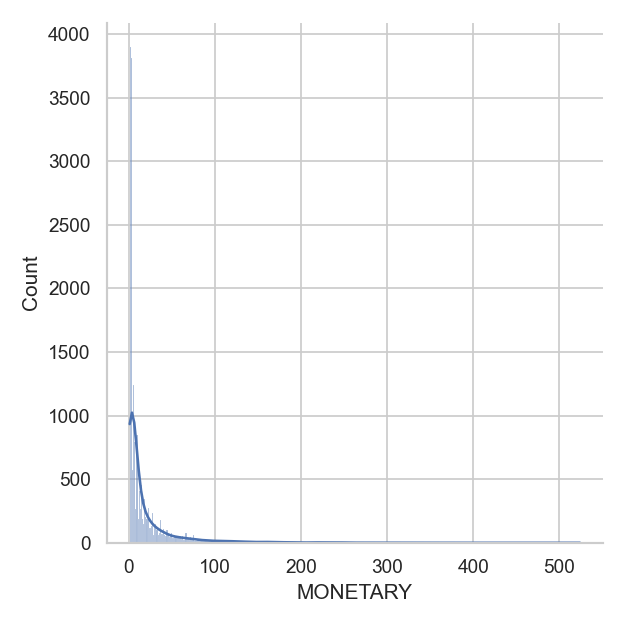

<IPython.core.display.Javascript object>


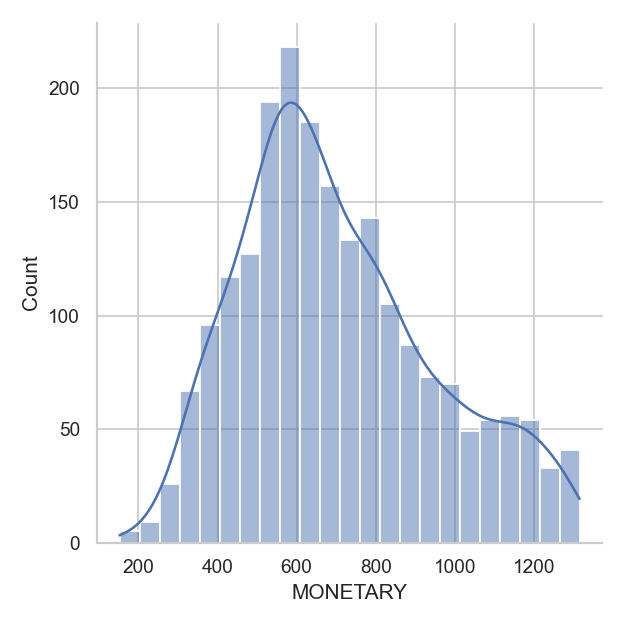

In [85]:
for i in range(4):
    sns.set_theme(style="whitegrid")
    sns.displot(data= final[final['Cluster_Id']== i], x="MONETARY", kde=True, fill=True, palette= "rocket")

<IPython.core.display.Javascript object>


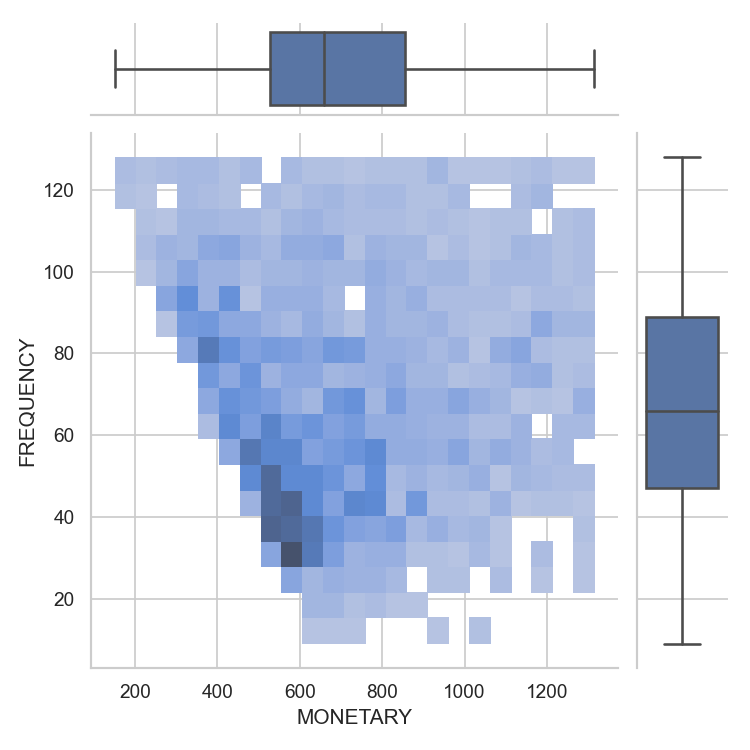

In [86]:
g = sns.JointGrid(data=final[final['Cluster_Id']== 3], x="MONETARY", y="FREQUENCY", palette = "rocket")
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

### Bivariate relationships [F & M]

<IPython.core.display.Javascript object>


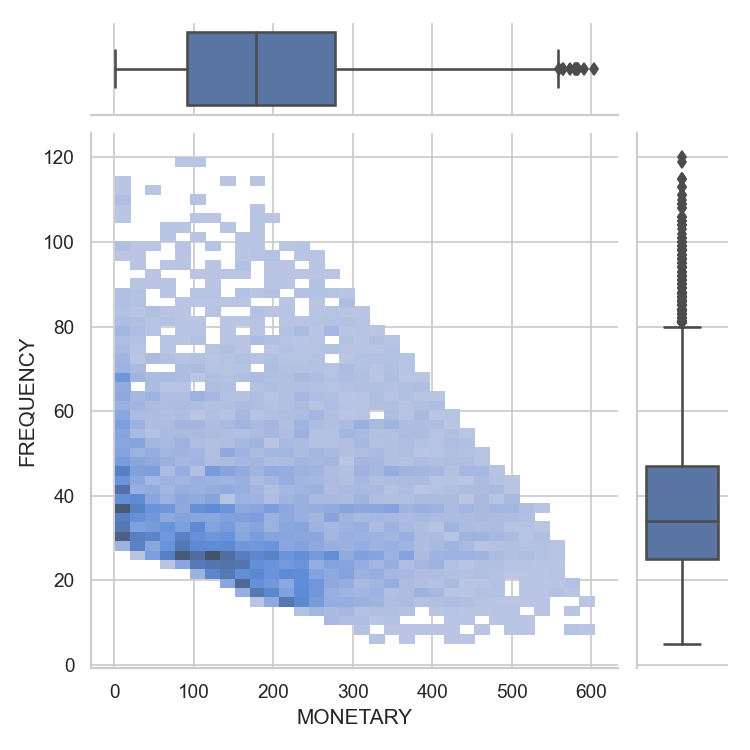

<IPython.core.display.Javascript object>


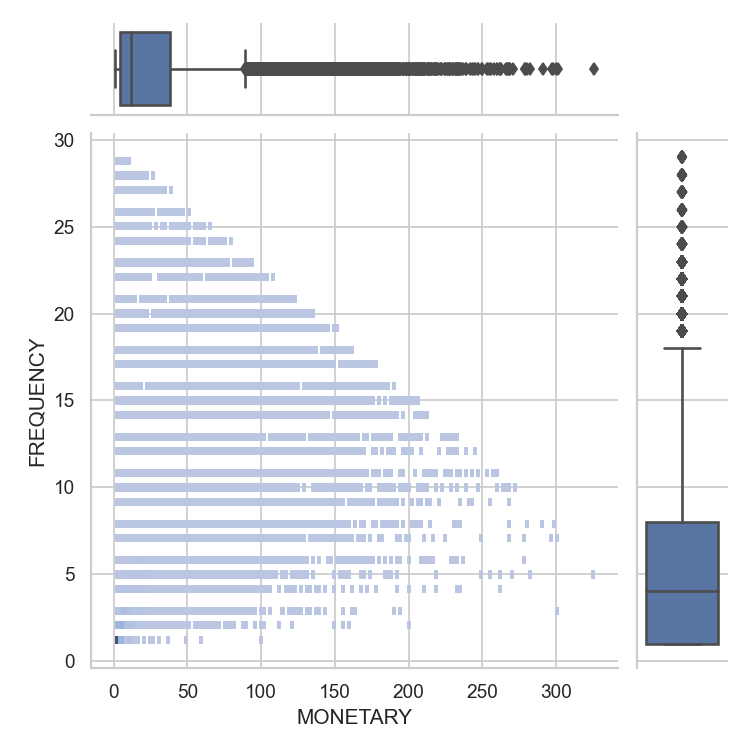

<IPython.core.display.Javascript object>


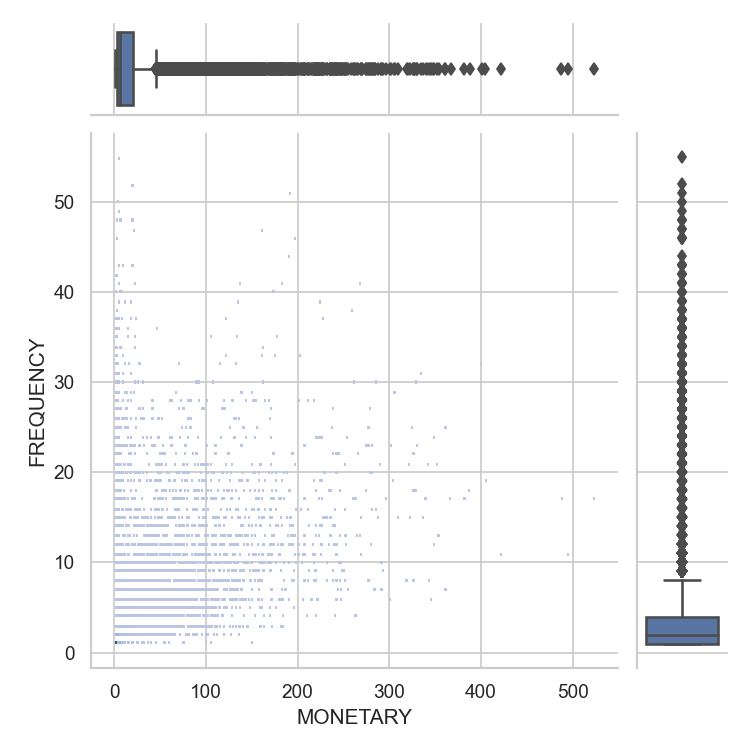

<IPython.core.display.Javascript object>


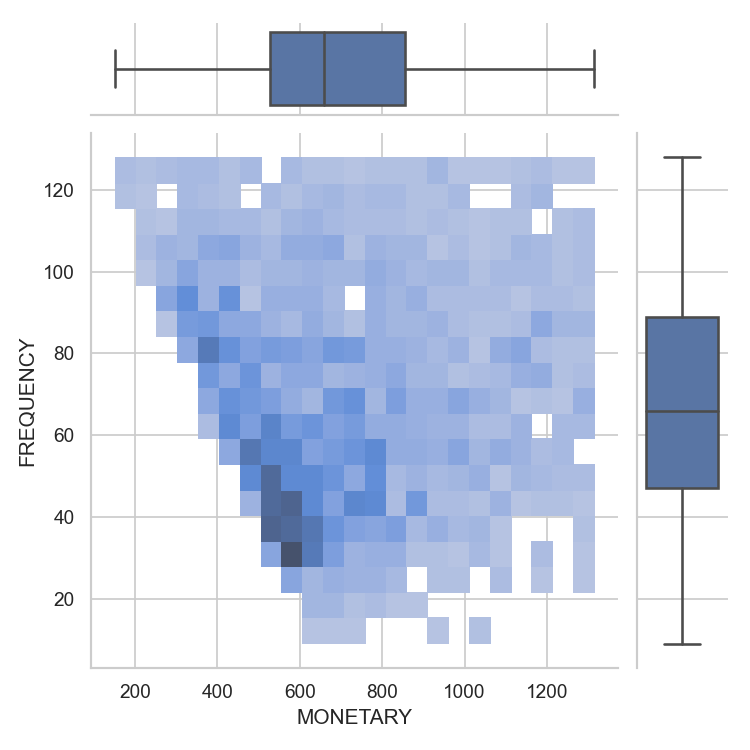

In [87]:
for i in range(4):
    g = sns.JointGrid(data=final[final['Cluster_Id']== i], x="MONETARY", y="FREQUENCY", palette = "rocket")
    g.plot_joint(sns.histplot)
    g.plot_marginals(sns.boxplot)